# 1. Encoder-Decoders

<b>Encoder-decoder</b> architecture has been pioneered in 2014, primarily being the core technology behind Google Translator.

This architecture works as a multi-label classification, with an Encoder Vector as lower dimensional representation of the data, connecting the inputs and outputs.

When we use the same data as input and output, we have an Autoencoder. Autoencoders can be used for:
- Dimensionality reduction: Smaller dimension space representation of the inputs
- De-noising data: When trained with clean data, the model can filter out noise during reconstruction
- Anomaly detection: If the input has unseen information to the model, which means an anomaly, the output will be a poor reconstruction of the data.

To demonstrate the encoding-decoding process, we will create a very simple and basic Autoencoder for MNIST digits.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage.util import random_noise
from skimage.transform import resize

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Dataset mnist containing digit images
mnist = tf.keras.datasets.mnist.load_data()
(X_train, y_train), (X_test, y_test) = mnist
X_train_bin = X_train > 127
X_test_bin = X_test > 127

# Binarize them through threshold
X_train_bin = X_train_bin.reshape(-1, 784)
X_test_bin = X_test_bin.reshape(-1, 784)

In [3]:
# Build our autoencoder
autoencoder = Sequential()
autoencoder.add(Dense(32, activation='relu', input_shape=(784,)))
autoencoder.add(Dense(784, activation='sigmoid'))

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [4]:
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                25120     
                                                                 
 dense_1 (Dense)             (None, 784)               25872     
                                                                 
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [5]:
# Training the autoencoder
early_stopping_monitor = EarlyStopping(patience=5)

autoencoder.fit(X_train_bin, X_train_bin, epochs=30,
                validation_split=0.1, callbacks=[early_stopping_monitor])

Epoch 1/30
1688/1688 [==============================] - 11s 4ms/step - loss: 0.1560 - val_loss: 0.0995
Epoch 2/30
1688/1688 [==============================] - 6s 3ms/step - loss: 0.0873 - val_loss: 0.0777
Epoch 3/30
1688/1688 [==============================] - 6s 4ms/step - loss: 0.0739 - val_loss: 0.0711
Epoch 4/30
1688/1688 [==============================] - 6s 3ms/step - loss: 0.0699 - val_loss: 0.0689
Epoch 5/30
1688/1688 [==============================] - 7s 4ms/step - loss: 0.0685 - val_loss: 0.0678
Epoch 6/30
1688/1688 [==============================] - 6s 3ms/step - loss: 0.0678 - val_loss: 0.0674
Epoch 7/30
1688/1688 [==============================] - 6s 4ms/step - loss: 0.0674 - val_loss: 0.0673
Epoch 8/30
1688/1688 [==============================] - 5s 3ms/step - loss: 0.0670 - val_loss: 0.0674
Epoch 9/30
1688/1688 [==============================] - 7s 4ms/step - loss: 0.0668 - val_loss: 0.0669
Epoch 10/30
1688/1688 [==============================] - 5s 3ms/step - loss: 0.06

In [7]:
# Build our encoder
encoder = Sequential()
encoder.add(autoencoder.layers[0])

encoded = encoder.predict(X_test_bin)

313/313 [==============================] - 1s 4ms/step


Our test set has 10 thousand digit images. After being encoded, each image is represented by 32 values, instead of 784 (28x28) pixels.

In [8]:
encoded.shape

(10000, 32)

In [9]:
# Build our decoder
decoder = Sequential()
decoder.add(autoencoder.layers[1])

decoded = decoder.predict(encoded)

313/313 [==============================] - 0s 1ms/step


In [10]:
def find_idxs(labels, num=None):
  idxs = []
  n = 0
  if num is None:
    for i in range(len(labels)):
      if labels[i] == n:
        idxs.append(i)
        n += 1
      if n == 10:
        break
  else:
    for i in range(len(labels)):
      if labels[i] == num:
        idxs.append(i)
        n += 1
      if n == 5:
        break
  return idxs

In [11]:
def draw_digits(imgs, idxs, title):
  fig, ax = plt.subplots(2, 5, figsize=(6, 2))

  row = 0
  col = 0
  for i in idxs:
    ax[row][col].imshow(imgs[i], cmap=plt.cm.gray)
    ax[row][col].get_xaxis().set_visible(False)
    ax[row][col].get_yaxis().set_visible(False)
    col += 1
    if col == 5:
      row += 1
      col = 0

  fig.suptitle(title)
  plt.show()

In [12]:
def compare_digits(imgs, compare_imgs, idxs, noisy=False):
  fig, ax = plt.subplots(2, 5, figsize=(6, 2))

  col = 0
  if noisy == False:
    for i in idxs:
      ax[0][col].imshow(imgs[i], cmap=plt.cm.gray)
      ax[0][col].get_xaxis().set_visible(False)
      ax[0][col].get_yaxis().set_visible(False)

      ax[1][col].imshow(compare_imgs[i], cmap=plt.cm.gray)
      ax[1][col].get_xaxis().set_visible(False)
      ax[1][col].get_yaxis().set_visible(False)
      col += 1
    fig.suptitle('Original x Decoded')
  else:
    for i in idxs:
      ax[0][col].imshow(imgs[i], cmap=plt.cm.gray)
      ax[0][col].get_xaxis().set_visible(False)
      ax[0][col].get_yaxis().set_visible(False)
      col += 1
    col = 0
    for i in range(5):
      ax[1][col].imshow(compare_imgs[i], cmap=plt.cm.gray)
      ax[1][col].get_xaxis().set_visible(False)
      ax[1][col].get_yaxis().set_visible(False)
      col += 1
    fig.suptitle('Original x Noisy')
  plt.show()

In [13]:
def plot_encoded(imgs, idxs):
  fig, ax = plt.subplots(1, 5, figsize=(6, 4))

  for i, idx in enumerate(idxs):
    img = imgs[idx].reshape(8,4)
    ax[i].matshow(img, cmap='YlOrRd')
    ax[i].get_xaxis().set_visible(False)
    ax[i].get_yaxis().set_visible(False)

  fig.suptitle('Encoded Information')
  plt.show()

Belo we show examples of each digit, before and after encoding/decoding.

In [14]:
idxs = find_idxs(y_test)

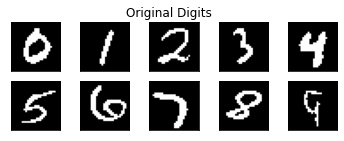

In [15]:
draw_digits(X_test_bin.reshape(-1, 28, 28), idxs, 'Original Digits')

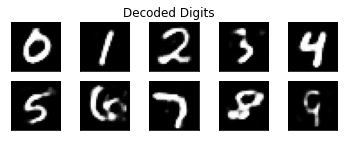

In [16]:
draw_digits(decoded.reshape(-1, 28, 28), idxs, 'Decoded Digits')

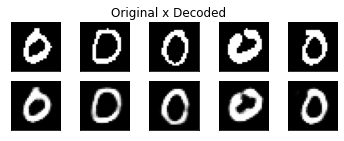

In [17]:
idxs = find_idxs(y_test, 0)
compare_digits(X_test_bin.reshape(-1, 28, 28),
               decoded.reshape(-1, 28, 28),
               idxs)

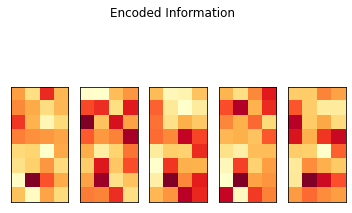

In [18]:
plot_encoded(encoded, idxs)

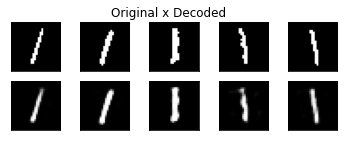

In [19]:
idxs = find_idxs(y_test, 1)
compare_digits(X_test_bin.reshape(-1, 28, 28),
               decoded.reshape(-1, 28, 28),
               idxs)

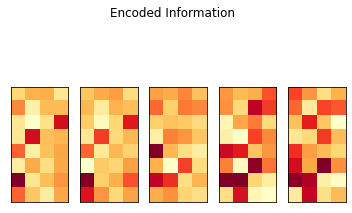

In [20]:
plot_encoded(encoded, idxs)

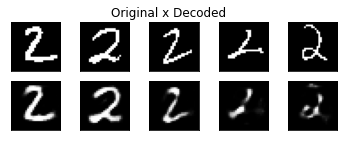

In [21]:
idxs = find_idxs(y_test, 2)
compare_digits(X_test_bin.reshape(-1, 28, 28),
               decoded.reshape(-1, 28, 28),
               idxs)

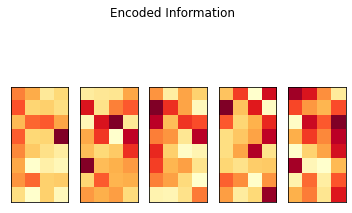

In [22]:
plot_encoded(encoded, idxs)

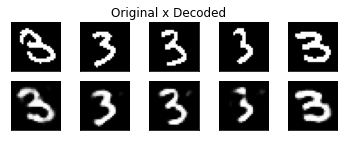

In [23]:
idxs = find_idxs(y_test, 3)
compare_digits(X_test_bin.reshape(-1, 28, 28),
               decoded.reshape(-1, 28, 28),
               idxs)

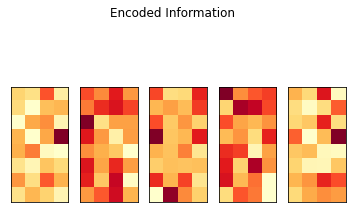

In [24]:
plot_encoded(encoded, idxs)

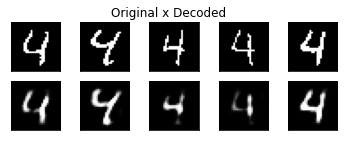

In [25]:
idxs = find_idxs(y_test, 4)
compare_digits(X_test_bin.reshape(-1, 28, 28),
               decoded.reshape(-1, 28, 28),
               idxs)

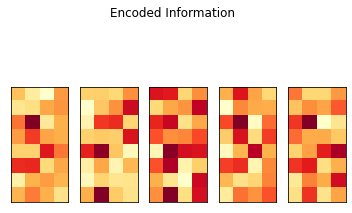

In [26]:
plot_encoded(encoded, idxs)

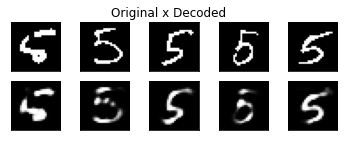

In [27]:
idxs = find_idxs(y_test, 5)
compare_digits(X_test_bin.reshape(-1, 28, 28),
               decoded.reshape(-1, 28, 28),
               idxs)

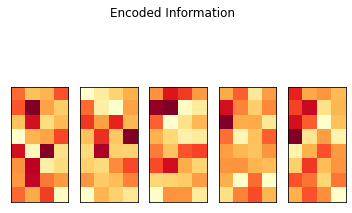

In [28]:
plot_encoded(encoded, idxs)

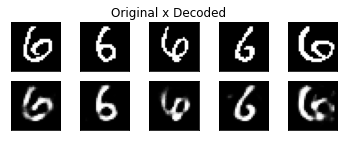

In [29]:
idxs = find_idxs(y_test, 6)
compare_digits(X_test_bin.reshape(-1, 28, 28),
               decoded.reshape(-1, 28, 28),
               idxs)

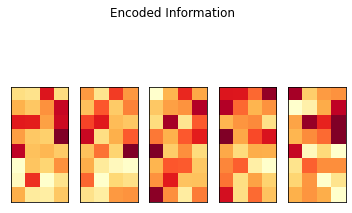

In [30]:
plot_encoded(encoded, idxs)

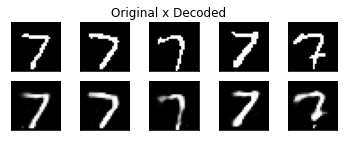

In [31]:
idxs = find_idxs(y_test, 7)
compare_digits(X_test_bin.reshape(-1, 28, 28),
               decoded.reshape(-1, 28, 28),
               idxs)

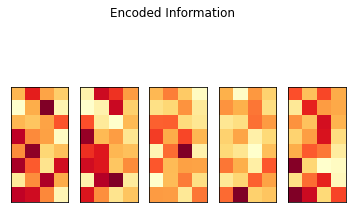

In [32]:
plot_encoded(encoded, idxs)

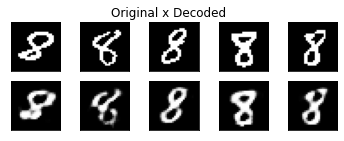

In [33]:
idxs = find_idxs(y_test, 8)
compare_digits(X_test_bin.reshape(-1, 28, 28),
               decoded.reshape(-1, 28, 28),
               idxs)

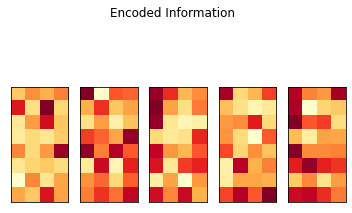

In [34]:
plot_encoded(encoded, idxs)

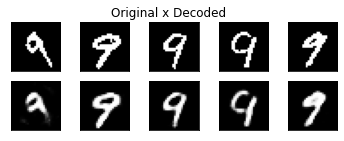

In [35]:
idxs = find_idxs(y_test, 9)
compare_digits(X_test_bin.reshape(-1, 28, 28),
               decoded.reshape(-1, 28, 28),
               idxs)

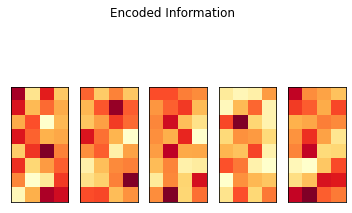

In [36]:
plot_encoded(encoded, idxs)

## 1.1. De-noising application

We will pick 5 digits, artificially add some noise and apply the encoding/decoding to remove the noise.

In [40]:
np.random.seed(10)
idxs = np.random.choice(len(y_test), 5)

In [41]:
X_test_noisy = []
for i in idxs:
  X_test_noisy.append(random_noise(X_test_bin[i, :].reshape(28, 28), seed=20,
                                    mode='salt', amount=0.1).reshape(-1, 784))
X_test_noisy = np.array(X_test_noisy).reshape(5, 784)

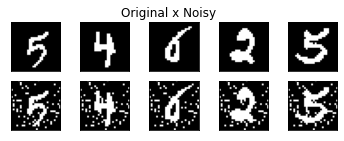

In [42]:
compare_digits(X_test_bin.reshape(-1, 28, 28),
               X_test_noisy.reshape(-1, 28, 28),
               idxs, noisy=True)

1/1 [==============================] - 0s 21ms/step


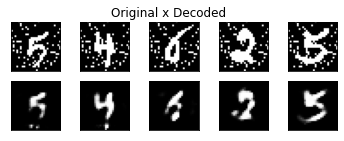

In [43]:
encoded_noisy = encoder.predict(X_test_noisy)
decoded_noisy = decoder.predict(encoded_noisy)

compare_digits(X_test_noisy.reshape(-1, 28, 28),
               decoded_noisy.reshape(-1, 28, 28),
               range(5))

## 1.2. Anomaly detection

For anomaly detection we will apply same encoder-decoder networks, with an image which is not a digit and look the output.

In [44]:
image = data.horse()
image = resize(image, (28, 28))
image = image == 0

In [45]:
encoded_img = encoder.predict(image.reshape(1, 784))
decoded_img = decoder.predict(encoded_img)

1/1 [==============================] - 0s 25ms/step


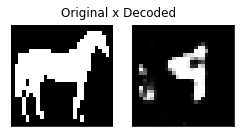

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(4, 2))
ax[0].imshow(image.reshape(28, 28), cmap=plt.cm.gray)
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)

ax[1].imshow(decoded_img.reshape(28, 28), cmap=plt.cm.gray)
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)

fig.suptitle('Original x Decoded')
plt.show()

# 2. Recurrent Neural Networks

Now let us take a step further, applying encoder-decoders. Recurrent Networks are built onto this architecture, but they expand its applications.

On our previous example, we built an autoencoder based on same data as input and output. Now imagine that, instead of encoding/decoding pixels from images, we encode/decode words from a corpus. With this concept we can grow into larger models with more complex relationships.

<b>LSTM</b> (Long Short Term Memory) structure is a Recurrent Network topology which uses Encoding/Decoding layers to build the model's input and output. Added to this, we have a recurrent structure, which linkages entire sentences, giving a sence of memory and importance to sentence order.

Since Recurrent Networks are able to capture sequence importance, it allows many different applications, such as:
- Speech to written text transformation;
- Language translation;
- Document summarization;
- Musical composition;
- Image captioning;
- Text generation/prediction;
- Time series modeling.

## 2.1. Text Generation

We will perform a simple example below, creating a simple model for word prediction, based on a text corpus.

Based on the text from the book <i>Lord of the Rings: The Fellowship of the Ring</i>, our LSTM model will be trained to predict a fourth word, based on previous three. Since our model is extremely simple, for each sentence we want to predict, we will actually show the top 5 words with highest probabilities predicted.

In [47]:
import string
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping

In [48]:
# We pre-process the text, by removing all new line characters, as well as punctuations.
text = ''
file = '/content/01 - The Fellowship Of The Ring.txt'
with open(file, encoding = "ISO-8859-1") as f:
  for line in f:
    line = line.replace('\n', '').strip()
    text += f' {line}'
text = text.translate(str.maketrans('', '', string.punctuation))
text = text.replace('  ', ' ')

In [49]:
# We first separate each single word, and then build the sentences of 4 words, separating into X and y.
words = text.split()
sentences = []
for i in range(4, len(words)+1):
  sentences.append(' '.join(words[i-4:i]))

tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
sequences = np.array(sequences)
X_train = sequences[:,:3]
y_train = sequences[:,-1]
y_train = to_categorical(y_train)
vocab_size = y_train.shape[1]

The entire book has 9475 different words, and this will be our vocabulary of possible words. It is important to note that we did not remove any stopwords, neither we applied lemmatization or stemming here.

In [50]:
vocab_size

9475

In [51]:
# We build our LSTM model
model = Sequential()
model.add(Embedding(input_dim = vocab_size, input_length = 3, output_dim= 128, ))
model.add(LSTM(32))
model.add(Dense(32, activation='relu'))
model.add(Dense(vocab_size, activation='softmax'))
model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy')

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3, 128)            1212800   
                                                                 
 lstm (LSTM)                 (None, 32)                20608     
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 9475)              312675    
                                                                 
Total params: 1,547,139
Trainable params: 1,547,139
Non-trainable params: 0
_________________________________________________________________


In order to represent our vocabulary of 9475 words, we applied Word Embedding, into 128 nodes. This layer is capable of representing our entire vocabulary in similarity vectors between words.

In the output of the LSTM model, it applies a Decoding layer, returning to 9475 nodes, where each one corresponds to a word of our vocabulary.

In [52]:
early_stopping_monitor = EarlyStopping(patience=3)

model.fit(X_train, y_train, epochs=50,
          validation_split=0.1, callbacks=[early_stopping_monitor])

Epoch 1/50
5272/5272 [==============================] - 47s 8ms/step - loss: 6.3767 - val_loss: 6.1868
Epoch 2/50
5272/5272 [==============================] - 39s 7ms/step - loss: 5.7815 - val_loss: 5.9766
Epoch 3/50
5272/5272 [==============================] - 41s 8ms/step - loss: 5.4433 - val_loss: 5.9700
Epoch 4/50
5272/5272 [==============================] - 38s 7ms/step - loss: 5.2379 - val_loss: 5.9936
Epoch 5/50
5272/5272 [==============================] - 37s 7ms/step - loss: 5.0861 - val_loss: 6.0796
Epoch 6/50
5272/5272 [==============================] - 37s 7ms/step - loss: 4.9617 - val_loss: 6.1536


In [53]:
def predict_text(test_text, model = model):
  # Tokenize the test_text, turning them into a sequence of numbers
  test_seq = tokenizer.texts_to_sequences([test_text])
  test_seq = np.array(test_seq)
  
  # Use the model to predict the next word. We capture the 5 highest probabilities.
  pred = model.predict(test_seq)
  pred = pred[0].argsort()[::-1][:5]
  
  # Return the words that map to the predictions
  words = []
  for p in pred:
    words.append(tokenizer.index_word[p])
  return words

In [54]:
predict_text('One Ring to')

1/1 [==============================] - 0s 438ms/step


['be', 'go', 'the', 'see', 'have']

In [55]:
predict_text('Fellowship of the')

1/1 [==============================] - 0s 28ms/step


['shire', 'road', 'ring', 'world', 'mountains']

In [56]:
predict_text('Men and Elves')

1/1 [==============================] - 0s 28ms/step


['and', 'said', 'but', 'were', 'had']

In [57]:
predict_text('Gandalf was a')

1/1 [==============================] - 0s 32ms/step


['long', 'while', 'great', 'little', 'few']

Althought not perfect, our model was capable of predicting words that could make sense in a sentence. For example the next word predicted for `Men and Elves` were mainly verb or connective, while the next word predicted for `Gandalf was a` were adjectives and the next word predicted for `Fellowship of the` were mainly nouns. The model was capable of extracting this structure, without ever learning grammar or word classes.

LSTM were revolutionary and brought many applications, but they also have several shortcomings:

- They are extremely slow to train;
- Their hidden state depends on the sequence order, so this topology doesn't allow for parallel computation;
- Big sequences provoke exploding or vanishing gradients problem.

# 3. Transformers Networks

So here enters the <b>Transformers</b>, introduced by Google Brain, in 2017. Transformers is a new Neural Network topology, that replaces the sequential computation by attention mechanism, in recurrent networks.

This topology is mainly used for Language Translation, but has also been widely used in top-notch medical researches like new drugs discovery and diseases research.

The Transformers presents:
- Lower computational complexity compared to previous RNNs topologies;
- Allows for parallel computation, since the recurrence feature is modelled by attention layers;
- The multi-head attention layers also solve the vanishing gradient problem, allowing longer sequences to be used.

Being a more complex and also bigger neural network, it became more and more necessary to apply Transfer Learning.

Below we present some examples, by applying pre-trained Transformers networks.

## 3.1. Language Translation

One main task is to perform Language Translation. This, however, is not a simple task, since different languages may have different grammar and phrase structure, and the model must be able to learn how to properly translate.

We show here a pre-trained model, from the NLP group from the University of Helsinki, built on MariamMT framework, which uses an engine built on C++ by Microsoft and academics.

In [58]:
!pip install transformers sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 44.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 75.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 26.1 MB/s eta 0:00:00


In [65]:
import pandas as pd
from transformers import MarianTokenizer, MarianMTModel
from transformers import AutoModelForQuestionAnswering, AutoTokenizer, pipeline

In [66]:
# Get the name of the model
model_name = 'Helsinki-NLP/opus-mt-tc-big-en-pt'

# Get the tokenizer
tokenizer = MarianTokenizer.from_pretrained(model_name)
# Instantiate the model
model = MarianMTModel.from_pretrained(model_name)

/usr/local/lib/python3.8/dist-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [67]:
def format_batch_texts(language_code, batch_texts):
  # Add target language token, so the model may identify the language
  formated_bach = [">>{}<< {}".format(language_code, text) for text in batch_texts]
  return formated_bach

In [68]:
def perform_translation(batch_texts, model, tokenizer, language="pt"):

  # Prepare the text data into appropriate format for the model
  formated_batch_texts = format_batch_texts(language, batch_texts)
 
  # Generate translation using model
  translated = model.generate(**tokenizer(formated_batch_texts, return_tensors="pt", padding=True))

  # Convert the generated tokens indices back into text
  translated_texts = [tokenizer.decode(t, skip_special_tokens=True) for t in translated]
 
  return translated_texts

In [69]:
english_texts = ["Artificial intelligence (AI) is intelligence - perceiving, synthesizing, and inferring information - demonstrated by machines, as opposed to intelligence displayed by non-human animals and humans.",
                 "Example tasks in which this is done include speech recognition, computer vision, translation between (natural) languages, as well as other mappings of inputs."]

# Check the model translation from the original language (English) to Portuguese
translated_texts = perform_translation(english_texts, model, tokenizer)

/usr/local/lib/python3.8/dist-packages/transformers/generation/utils.py:1273: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 512 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [72]:
print(f"English texts:\n{[text for text in english_texts]}")
print(f"\nTranslated Portuguese texts?\n{translated_texts}")

English texts:
['Artificial intelligence (AI) is intelligence - perceiving, synthesizing, and inferring information - demonstrated by machines, as opposed to intelligence displayed by non-human animals and humans.', 'Example tasks in which this is done include speech recognition, computer vision, translation between (natural) languages, as well as other mappings of inputs.']

Translated Portuguese texts?
['Inteligência artificial (IA) é inteligência - perceber, sintetizar e inferir informações - demonstradas por máquinas, em oposição à inteligência exibida por animais não humanos e humanos.', 'exemplo de tarefas em que isso é feito incluem reconhecimento de fala, visão computacional, tradução entre línguas (naturais), bem como outros mapeamentos de entradas.']


## 3.2. Question Answering

In [73]:
model_qa = "deepset/roberta-base-squad2"

task = 'question-answering'
QA_model = pipeline(task, model=model_qa, tokenizer=model_qa)

In [74]:
text = 'Artificial intelligence (AI) is intelligence - perceiving, synthesizing, and inferring information - demonstrated by machines, as opposed to intelligence displayed by non-human animals and humans. Example tasks in which this is done include speech recognition, computer vision, translation between (natural) languages, as well as other mappings of inputs. AI applications include advanced web search engines (e.g., Google Search), recommendation systems (used by YouTube, Amazon and Netflix), understanding human speech (such as Siri and Alexa), self-driving cars (e.g., Waymo), automated decision-making and competing at the highest level in strategic game systems (such as chess and Go). As machines become increasingly capable, tasks considered to require "intelligence" are often removed from the definition of AI, a phenomenon known as the AI effect. For instance, optical character recognition is frequently excluded from things considered to be AI, having become a routine technology. Artificial intelligence was founded as an academic discipline in 1956, and in the years since has experienced several waves of optimism, followed by disappointment and the loss of funding (known as an "AI winter"), followed by new approaches, success and renewed funding. AI research has tried and discarded many different approaches since its founding, including simulating the brain, modeling human problem solving, formal logic, large databases of knowledge and imitating animal behavior. In the first decades of the 21st century, highly mathematical-statistical machine learning has dominated the field, and this technique has proved highly successful, helping to solve many challenging problems throughout industry and academia.'

In [77]:
QA_input = {
          'question': 'What is Artificial Intelligence?',
          'context': text
          }

model_response = QA_model(QA_input)
print(f"Question: {QA_input['question']}")
print(f"Answer: {model_response['answer']}")

Question: What is Artificial Intelligence?
Answer: intelligence - perceiving, synthesizing, and inferring information


In [78]:
QA_input = {
          'question': 'When was Artificial Intelligence created?',
          'context': text
          }

model_response = QA_model(QA_input)
print(f"Question: {QA_input['question']}")
print(f"Answer: {model_response['answer']}")

Question: When was Artificial Intelligence created?
Answer: 1956


In [80]:
QA_input = {
          'question': 'What are the tools of Artificial Intelligence?',
          'context': text
          }

model_response = QA_model(QA_input)
print(f"Question: {QA_input['question']}")
print(f"Answer: {model_response['answer']}")

Question: What are the tools of Artificial Intelligence?
Answer: speech recognition, computer vision, translation between (natural) languages


In [83]:
QA_input = {
          'question': 'Which big companies use Artificial Intelligence?',
          'context': text
          }

model_response = QA_model(QA_input)
print(f"Question: {QA_input['question']}")
print(f"Answer: {model_response['answer']}")

Question: Which big companies use Artificial Intelligence?
Answer: YouTube, Amazon and Netflix


# 4. Conclusion

With the increase in size and complexity of neural network models, more efficient techniques of Transfer Learning had to be developed.

Currently we have these two state-of-the-art Transfer Learning models:
- BERT (Bidirectional Encoder Representations from Transformers): was developed in 2018 by Google. It helps to solve the most common language tasks such as NER (Named Entity Recognition), sentiment analysis, question-answering, text-summarization;
- GPT3 (Generative Pre-Training-3): was developed in 2020 by OpenAI. It is a multi-layer transformer, mainly used to generate new text. Its main application has been famous worldwide with the launch of ChatGPT.

With computational resources evolving faster and faster, AI area is also evolving, with new and interesting structures and topologies. We still have a lot more to evolve, not only in NLP, but in every area.